# Diagnose ensemble  initialization 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geocat.viz import util as gvutil

import datetime
import cf_units as cf
import dask

In [2]:
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

## 1. MPAS TEST RUNS

In [3]:
dir = '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/'
casename = 'f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2'

### 1.1 T2m diagnostics

In [17]:
filenames = f"{dir}{casename}*/atm/hist/regrid_TREFHT*.cam.h2a*.nc"
print(filenames)
glob.glob(filenames)

/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2*/atm/hist/regrid_TREFHT*.cam.h2a*.nc


['/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.06/atm/hist/regrid_TREFHT_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.06.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.09/atm/hist/regrid_TREFHT_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.09.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02/atm/hist/regrid_TREFHT_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.05/atm/hist/regrid_TREFHT_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.05.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00/atm/hist/regrid_TREFHT_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00.cam.h2a.2021-02-09-0

In [18]:
ds = xr.open_mfdataset(filenames,combine='nested',concat_dim='ens')

In [19]:
ds

<xarray.Dataset>
Dimensions:  (ens: 11, time: 14, lat: 719, lon: 1440)
Coordinates:
  * time     (time) object 2021-02-08 12:00:00 ... 2021-02-21 12:00:00
  * lat      (lat) float64 -89.75 -89.5 -89.25 -89.0 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Dimensions without coordinates: ens
Data variables:
    TREFHT   (ens, time, lat, lon) float32 dask.array<chunksize=(1, 14, 719, 1440), meta=np.ndarray>

In [20]:
ts_glob_mean = ds.TREFHT.mean(('lat','lon')).compute()

In [21]:
ts_us = ds.TREFHT.sel(lon=slice(220,290),lat=slice(20, 80))

Text(0.5, 1.0, 'Global Mean TS')

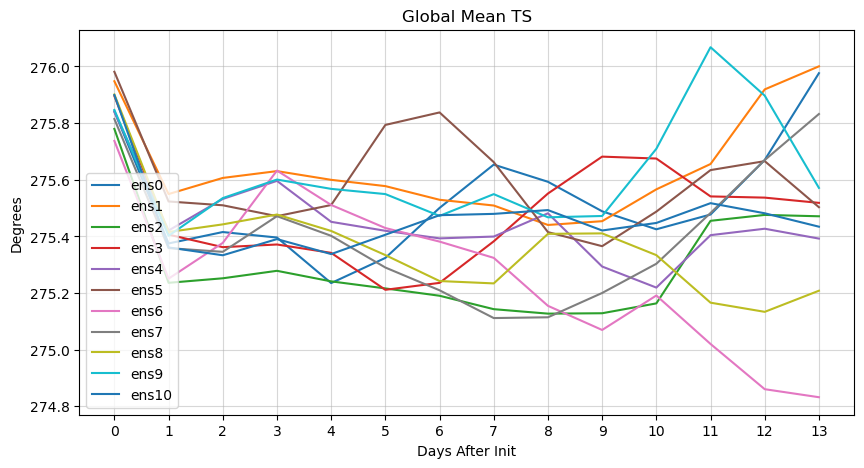

In [23]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,ts_glob_mean.isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(14))
#plt.ylim(275.5,277.0)
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('Global Mean TS')

(261.0, 269.0)

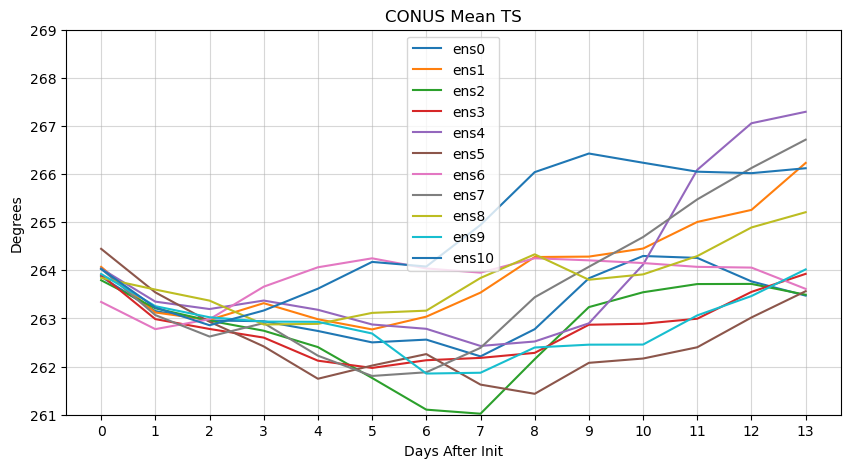

In [70]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,ts_us.mean(('lat','lon')).isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(14))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')
plt.ylim(261,269)

(261.0, 269.0)

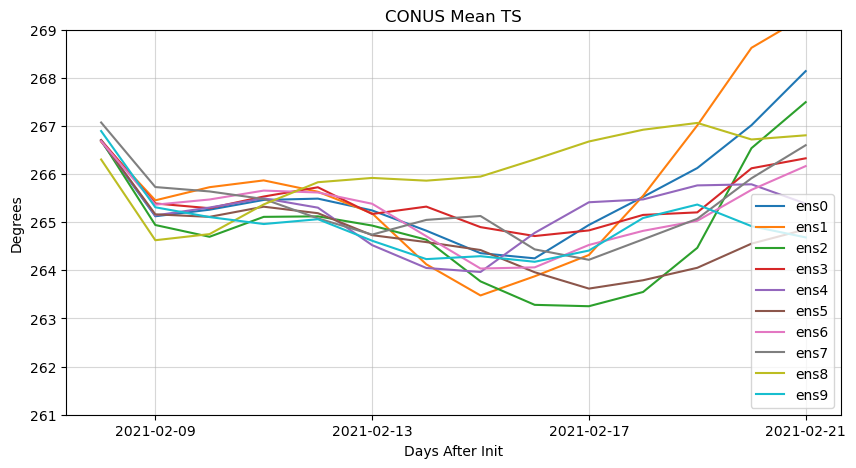

In [71]:
for ie in ds2.ens[0:10]:
    plt.plot(ds2.time[0:14],ts2_us.mean(('lat','lon')).isel(ens=ie,time=slice(0,14)),label="ens"+str(ds2.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
#plt.xticks(ds2.time.dt.day,np.arange(46))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')
plt.ylim(261,269)

#### 1.1.1 Plot some maps

In [13]:
## define plotting funcition

def var_plot_panels(variable, nrows, ncols, i, levels, title,colormap):
    ax1= fig.add_subplot(nrows, ncols, i, projection=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE, linewidth=4, zorder=2)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                            cmap = colormap,#'jet', #'viridis',
                           extend='both',
                           add_colorbar=False,
                           add_labels=False)
    cb = plt.colorbar(contour,
                     ax=ax1,
#                     ticks=ticks,
                     orientation='horizontal',
                     pad=0.1,
                     drawedges=True,
                     shrink=0.7,
                    # labelsize=20
                    )
        
    cb.ax.tick_params(labelsize=10)


    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=10)

    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-140,-70),
                                    ylim=(20, 80),
                                    xticks=np.linspace(-140,-70, 5),
                                    yticks=np.linspace(20, 80, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=10)
    gvutil.add_lat_lon_ticklabels(ax1)


In [25]:
ts_us_diff = ts_us.copy(data = (ts_us - ts_us.isel(ens=0)).data)

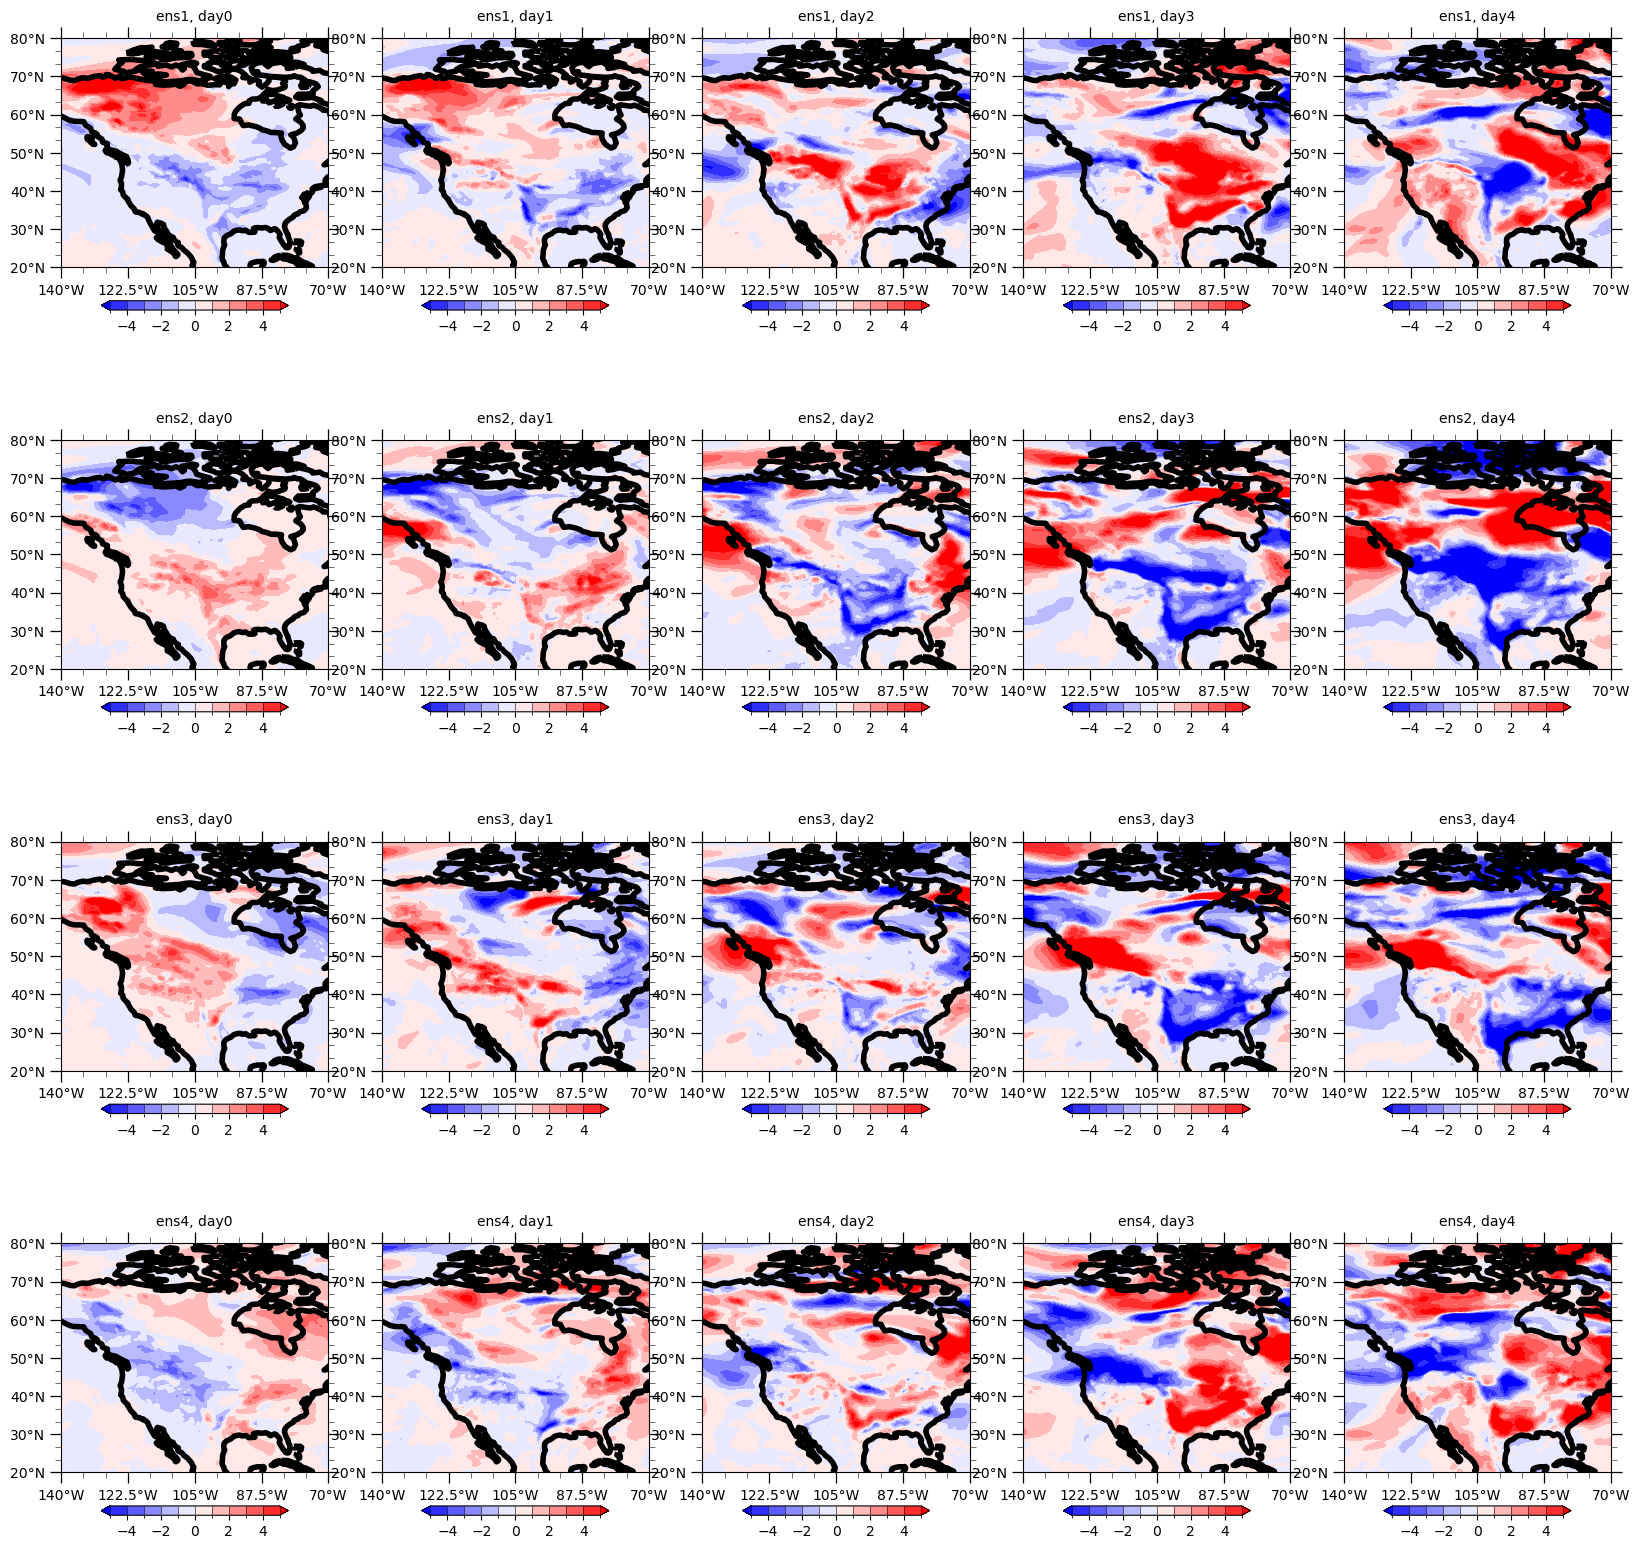

In [26]:
fig=plt.figure(figsize=(20,20))
levels=np.arange(-5,6,1)
var_plot_panels(ts_us_diff[1,0],4,5,1, levels,'ens1, day0','bwr')
var_plot_panels(ts_us_diff[1,1],4,5,2, levels,'ens1, day1','bwr')
var_plot_panels(ts_us_diff[1,2],4,5,3, levels,'ens1, day2','bwr')
var_plot_panels(ts_us_diff[1,3],4,5,4, levels,'ens1, day3','bwr')
var_plot_panels(ts_us_diff[1,4],4,5,5, levels,'ens1, day4','bwr')

var_plot_panels(ts_us_diff[2,0],4,5,6, levels,'ens2, day0','bwr')
var_plot_panels(ts_us_diff[2,1],4,5,7, levels,'ens2, day1','bwr')
var_plot_panels(ts_us_diff[2,2],4,5,8, levels,'ens2, day2','bwr')
var_plot_panels(ts_us_diff[2,3],4,5,9, levels,'ens2, day3','bwr')
var_plot_panels(ts_us_diff[2,4],4,5,10, levels,'ens2, day4','bwr')

var_plot_panels(ts_us_diff[3,0],4,5,11, levels,'ens3, day0','bwr')
var_plot_panels(ts_us_diff[3,1],4,5,12, levels,'ens3, day1','bwr')
var_plot_panels(ts_us_diff[3,2],4,5,13, levels,'ens3, day2','bwr')
var_plot_panels(ts_us_diff[3,3],4,5,14, levels,'ens3, day3','bwr')
var_plot_panels(ts_us_diff[3,4],4,5,15, levels,'ens3, day4','bwr')

var_plot_panels(ts_us_diff[4,0],4,5,16, levels,'ens4, day0','bwr')
var_plot_panels(ts_us_diff[4,1],4,5,17, levels,'ens4, day1','bwr')
var_plot_panels(ts_us_diff[4,2],4,5,18, levels,'ens4, day2','bwr')
var_plot_panels(ts_us_diff[4,3],4,5,19, levels,'ens4, day3','bwr')
var_plot_panels(ts_us_diff[4,4],4,5,20, levels,'ens4, day4','bwr')

In [33]:
ts_us_ensmean = ts_us.mean('ens')

In [35]:
ts_us_change = ts_us_ensmean - ts_us_ensmean.isel(time=0)

In [36]:
ts_us_change

<xarray.DataArray 'TREFHT' (time: 14, lat: 241, lon: 281)>
dask.array<sub, shape=(14, 241, 281), dtype=float32, chunksize=(14, 241, 281), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2021-02-08 12:00:00 ... 2021-02-21 12:00:00
  * lat      (lat) float64 20.0 20.25 20.5 20.75 21.0 ... 79.25 79.5 79.75 80.0
  * lon      (lon) float64 220.0 220.2 220.5 220.8 ... 289.2 289.5 289.8 290.0

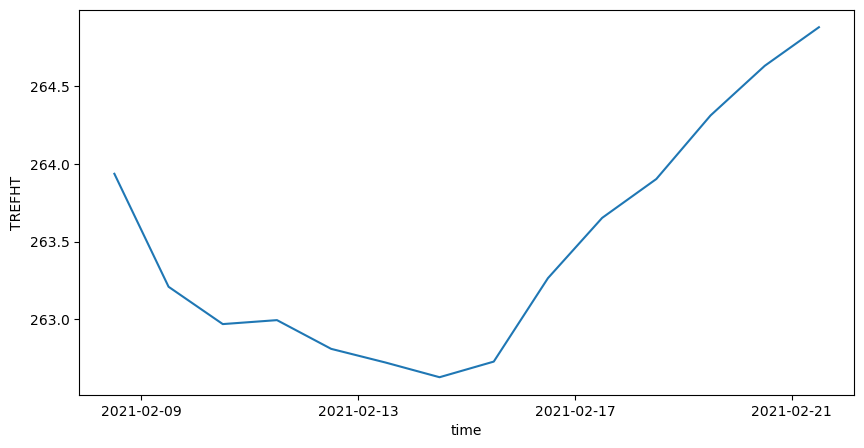

In [43]:
ts_us_ensmean.mean(('lat','lon')).plot()

### 1.2 Z500 diagnostics

In [4]:
filenames = f"{dir}{casename}*/atm/hist/regrid_Z500*.cam.h2a*.nc"
print(filenames)
glob.glob(filenames)

/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2*/atm/hist/regrid_Z500*.cam.h2a*.nc


['/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.06/atm/hist/regrid_Z500_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.06.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.09/atm/hist/regrid_Z500_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.09.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02/atm/hist/regrid_Z500_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.02.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.05/atm/hist/regrid_Z500_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.05.cam.h2a.2021-02-09-00000.nc',
 '/glade/derecho/scratch/huili7/ENSEMBLES/S2Scfsv2/archive/f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00/atm/hist/regrid_Z500_f.e23b17.FLTHIST_mpasa60.S2S.L58_S2Scfsv2.00.cam.h2a.2021-02-09-00000.nc',


In [5]:
ds = xr.open_mfdataset(filenames,combine='nested',concat_dim='ens')
ds

<xarray.Dataset>
Dimensions:  (ens: 11, time: 14, lat: 719, lon: 1440)
Coordinates:
  * time     (time) object 2021-02-08 12:00:00 ... 2021-02-21 12:00:00
  * lat      (lat) float64 -89.75 -89.5 -89.25 -89.0 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Dimensions without coordinates: ens
Data variables:
    Z500     (ens, time, lat, lon) float32 dask.array<chunksize=(1, 14, 719, 1440), meta=np.ndarray>

In [6]:
z500_glob_mean = ds.Z500.mean(('lat','lon')).compute()

In [7]:
z500_us = ds.Z500.sel(lon=slice(220,290),lat=slice(20, 80))

Text(0.5, 1.0, 'Global Mean Z500')

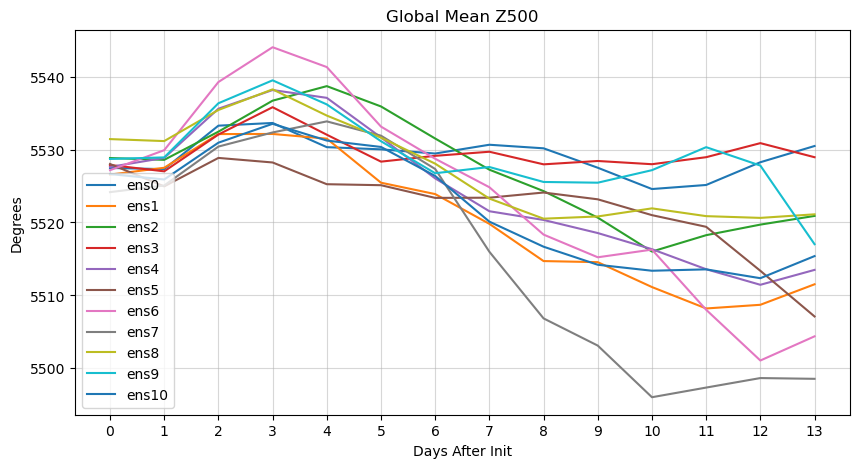

In [9]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,z500_glob_mean.isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(14))
#plt.ylim(275.5,277.0)
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('Global Mean Z500')

Text(0.5, 1.0, 'CONUS Mean TS')

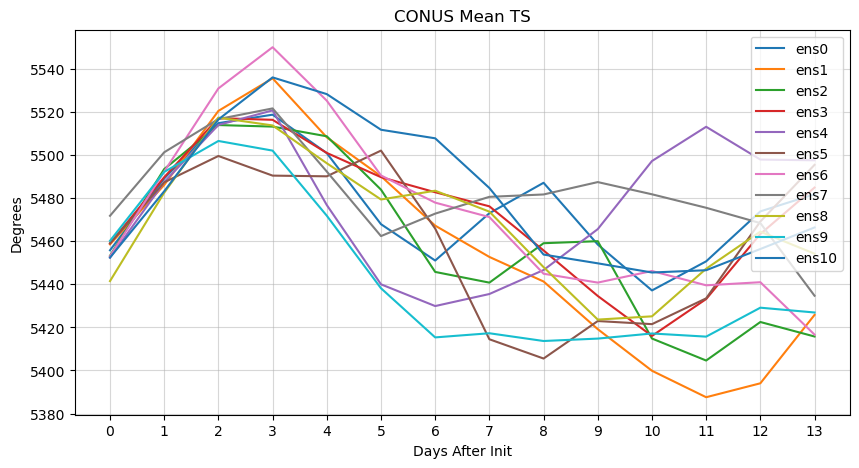

In [10]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day,z500_us.mean(('lat','lon')).isel(ens=ie),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(14))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')

#### 1.2.1 Plot some maps

In [11]:
z500_us_diff = z500_us.copy(data = (z500_us - z500_us.isel(ens=0)).data)

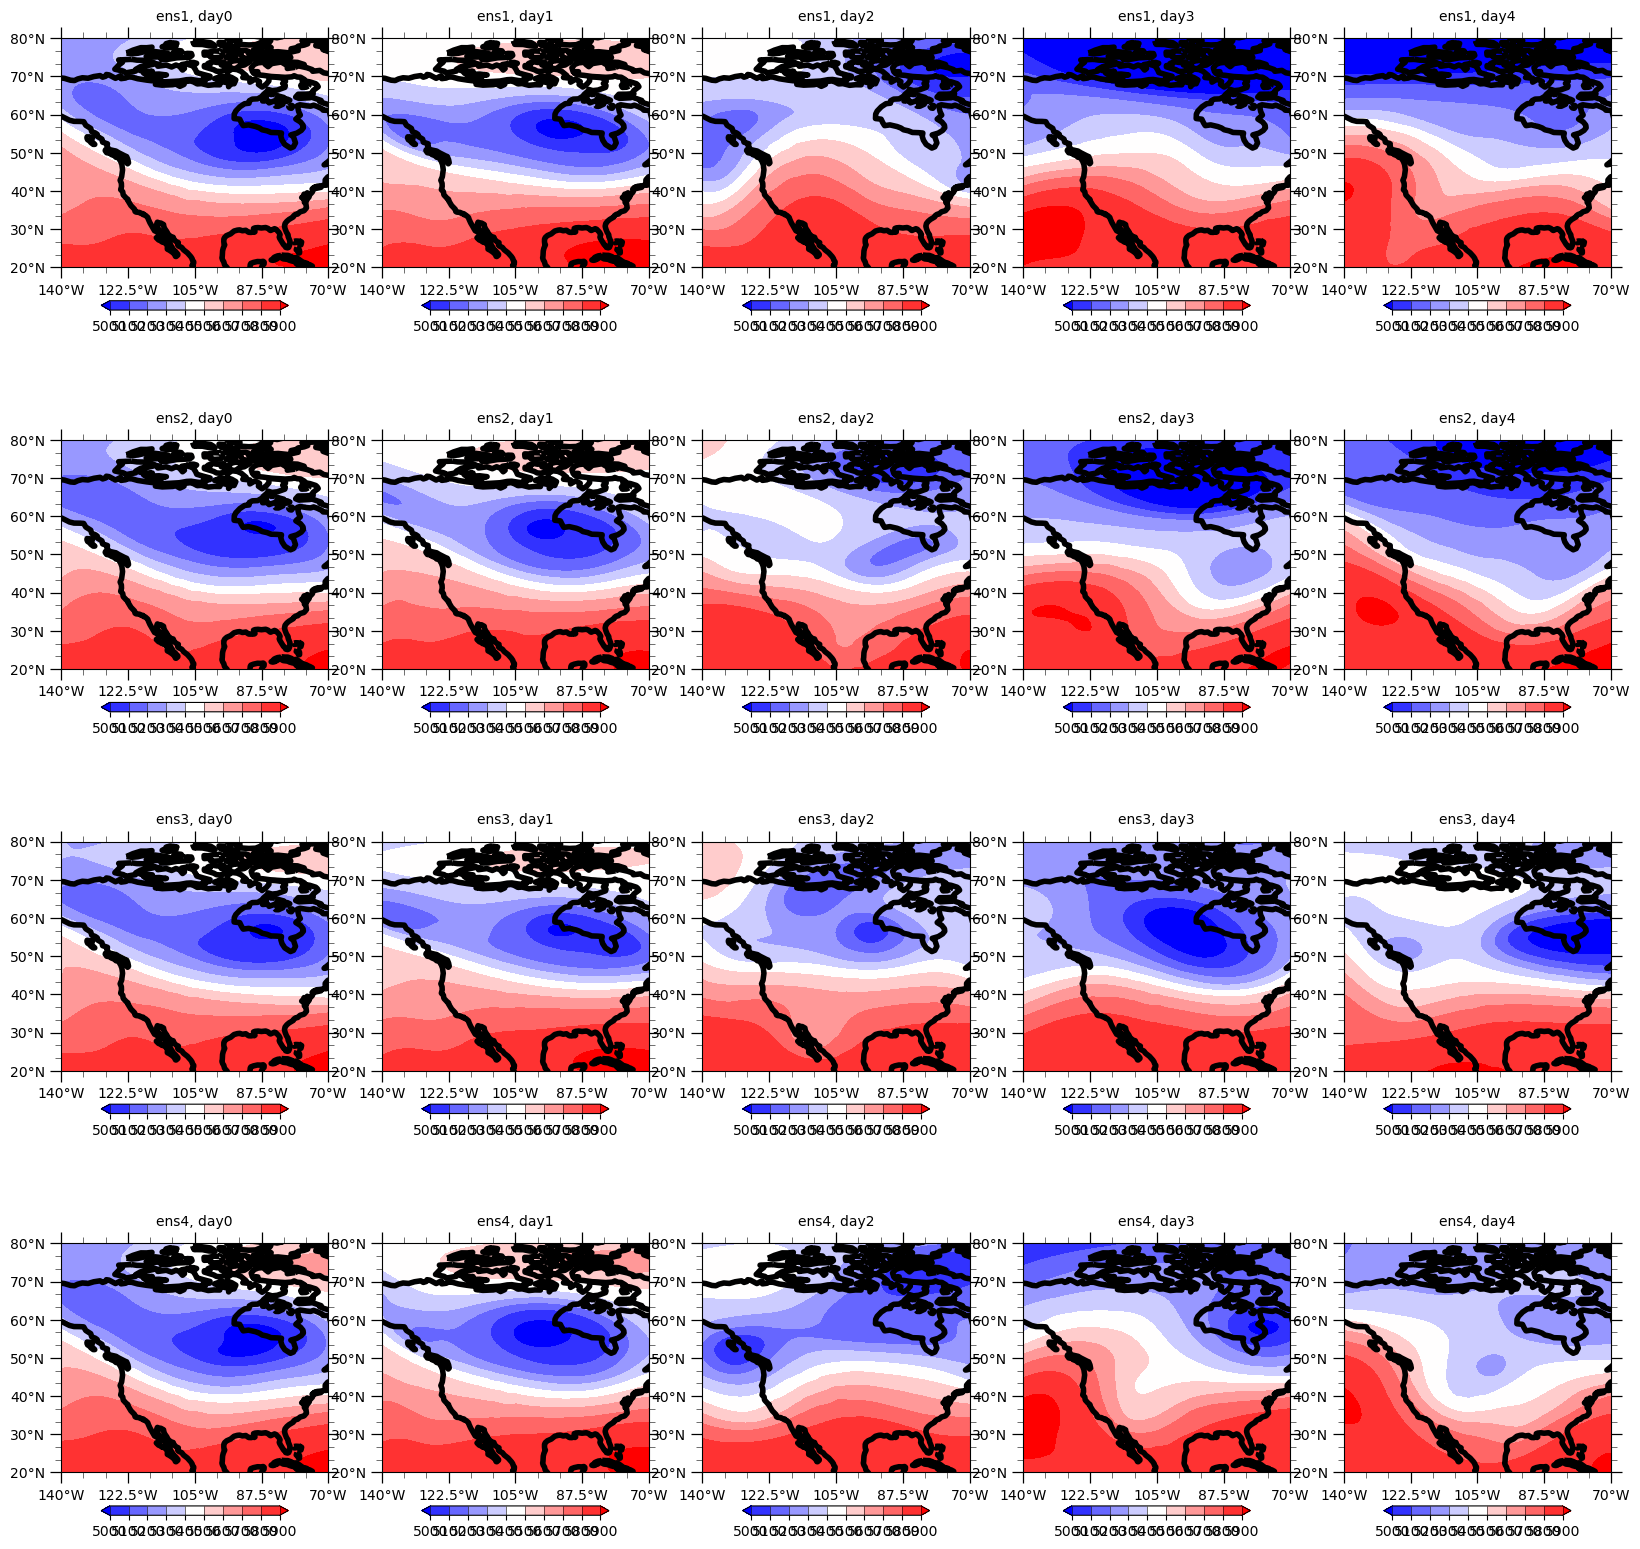

In [15]:
fig=plt.figure(figsize=(20,20))
levels=np.arange(5000,6000,100)
var_plot_panels(ds.Z500[1,0],4,5,1, levels,'ens1, day0','bwr')
var_plot_panels(ds.Z500[1,1],4,5,2, levels,'ens1, day1','bwr')
var_plot_panels(ds.Z500[1,5],4,5,3, levels,'ens1, day2','bwr')
var_plot_panels(ds.Z500[1,10],4,5,4, levels,'ens1, day3','bwr')
var_plot_panels(ds.Z500[1,13],4,5,5, levels,'ens1, day4','bwr')
var_plot_panels(ds.Z500[2,0],4,5,6, levels,'ens2, day0','bwr')
var_plot_panels(ds.Z500[2,1],4,5,7, levels,'ens2, day1','bwr')
var_plot_panels(ds.Z500[2,5],4,5,8, levels,'ens2, day2','bwr')
var_plot_panels(ds.Z500[2,10],4,5,9, levels,'ens2, day3','bwr')
var_plot_panels(ds.Z500[2,13],4,5,10, levels,'ens2, day4','bwr')
var_plot_panels(ds.Z500[3,0],4,5,11, levels,'ens3, day0','bwr')
var_plot_panels(ds.Z500[3,1],4,5,12, levels,'ens3, day1','bwr')
var_plot_panels(ds.Z500[3,5],4,5,13, levels,'ens3, day2','bwr')
var_plot_panels(ds.Z500[3,10],4,5,14, levels,'ens3, day3','bwr')
var_plot_panels(ds.Z500[3,13],4,5,15, levels,'ens3, day4','bwr')
var_plot_panels(ds.Z500[4,0],4,5,16, levels,'ens4, day0','bwr')
var_plot_panels(ds.Z500[4,1],4,5,17, levels,'ens4, day1','bwr')
var_plot_panels(ds.Z500[4,5],4,5,18, levels,'ens4, day2','bwr')
var_plot_panels(ds.Z500[4,10],4,5,19, levels,'ens4, day3','bwr')
var_plot_panels(ds.Z500[4,13],4,5,20, levels,'ens4, day4','bwr')

## 2. check cesm2 s2s

### 2.1 TS 

In [45]:
dir2= "/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/"
filenames2 = f"{dir2}tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m*.nc"
glob.glob(filenames2)

['/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m12.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m10.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m00.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m17.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m18.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m19.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/02/tas_2m_cesm2cam6v2_08feb2021_00z_d01_d46_m14.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S

In [46]:
ds2= xr.open_mfdataset(filenames2,combine='nested',concat_dim='ens')
ds2

<xarray.Dataset>
Dimensions:  (time: 46, lat: 181, lon: 360, ens: 22)
Coordinates:
  * time     (time) object 2021-02-08 00:00:00 ... 2021-03-25 00:00:00
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Dimensions without coordinates: ens
Data variables:
    tas_2m   (ens, time, lat, lon) float32 dask.array<chunksize=(1, 46, 181, 360), meta=np.ndarray>

In [48]:
ts2_mean = ds2.tas_2m.mean(('lat','lon')).compute()

In [49]:
ts2_us = ds2.tas_2m.sel(lon=slice(220,290),lat=slice(20, 80))
ts2_us_mean = ts2_us.mean(('lat','lon'))

Text(0.5, 1.0, 'CONUS Mean TS')

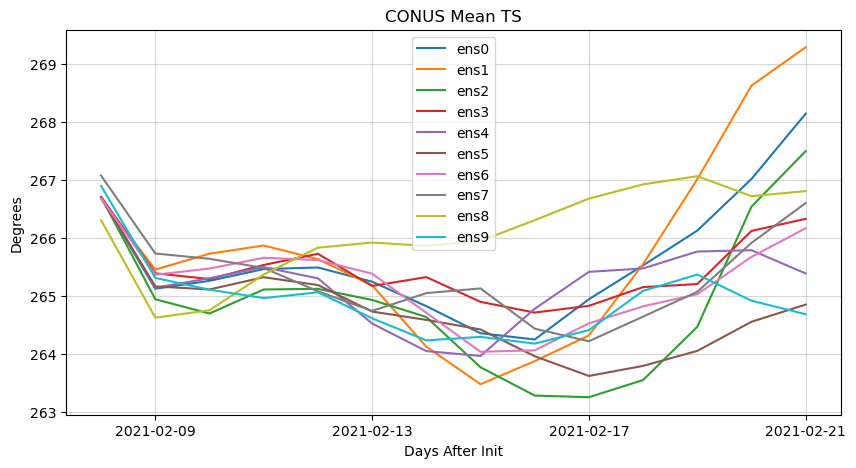

In [62]:
for ie in ds2.ens[0:10]:
    plt.plot(ds2.time[0:14],ts2_us.mean(('lat','lon')).isel(ens=ie,time=slice(0,14)),label="ens"+str(ds2.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
#plt.xticks(ds2.time.dt.day,np.arange(46))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')

In [ ]:
ts2_diff = ds2.ts.copy(data = (ds2.ts - ds2.ts.isel(ens=0)).data)

In [22]:
ts2_us_diff = ts2_us.copy(data = (ts2_us - ts2_us.isel(ens=0)).data)

Text(0.5, 1.0, 'CONUS Mean TS')

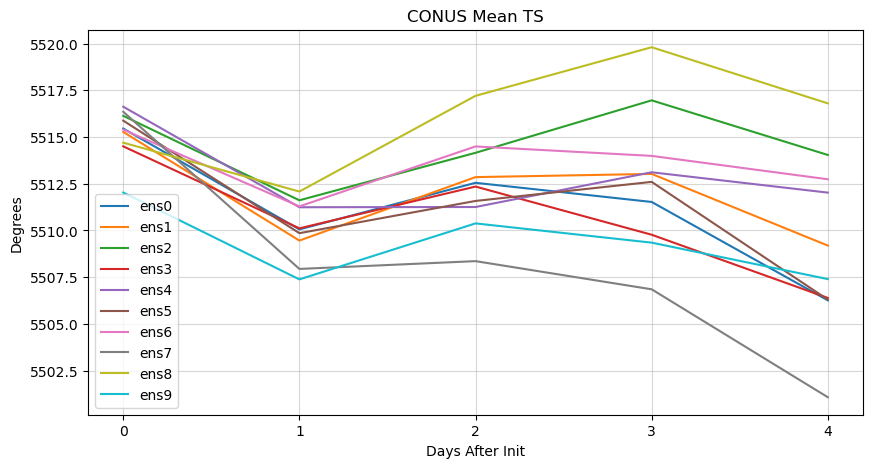

In [33]:
for ie in ds2.ens:
    plt.plot(ds2.time.dt.day[0:5],z500_mean2.isel(ens=ie,time=np.arange(5)),label="ens"+str(ds2.ens[ie].data))

plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(5))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')

Text(0.5, 1.0, 'CONUS Mean TS')

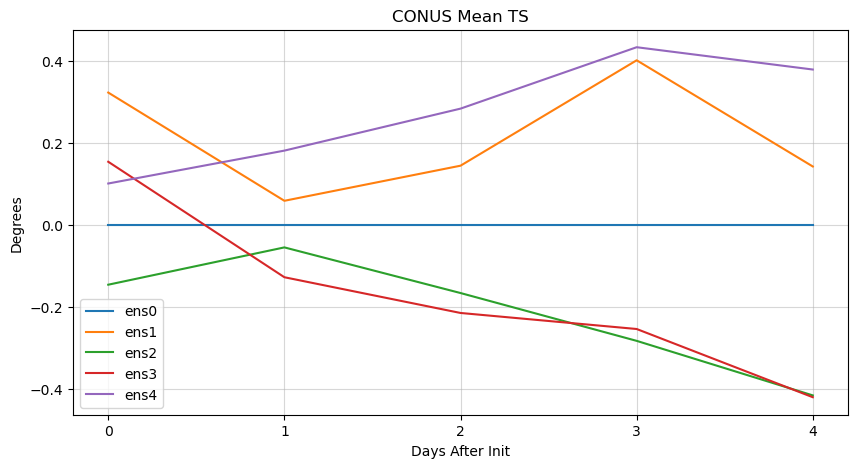

In [47]:
for ie in ds.ens:
    plt.plot(ds.time.dt.day[0:5],ts_us_diff.mean(('lat','lon')).isel(ens=ie,time=np.arange(5)),label="ens"+str(ds.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds.time.dt.day,np.arange(5))
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('CONUS Mean TS')

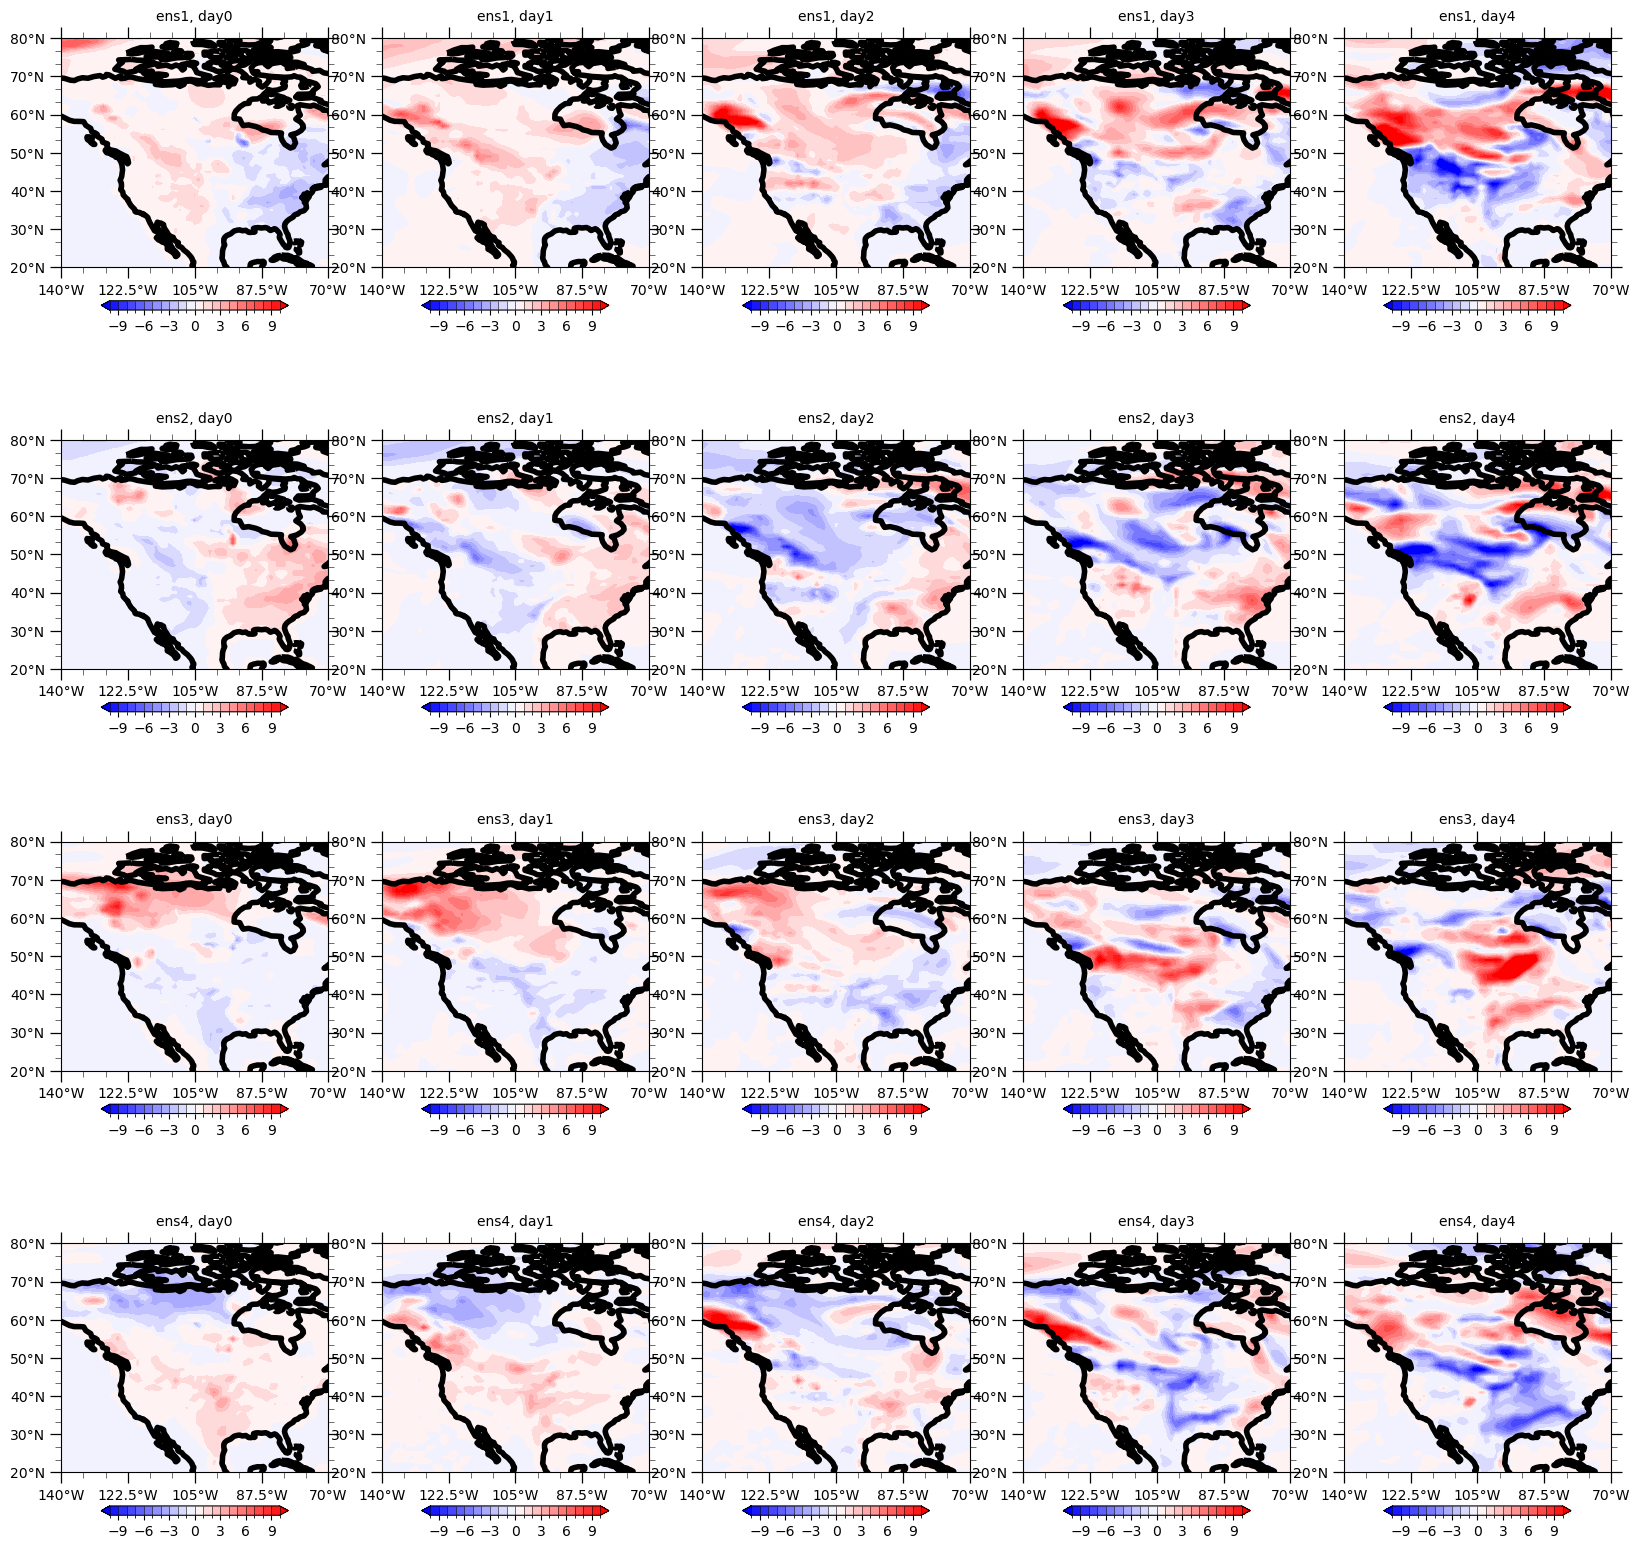

In [49]:
fig=plt.figure(figsize=(20,20))
levels=np.arange(-10,11,1)
var_plot_panels(ts2_us_diff[1,0],4,5,1, levels,'ens1, day0','bwr')
var_plot_panels(ts2_us_diff[1,1],4,5,2, levels,'ens1, day1','bwr')
var_plot_panels(ts2_us_diff[1,2],4,5,3, levels,'ens1, day2','bwr')
var_plot_panels(ts2_us_diff[1,3],4,5,4, levels,'ens1, day3','bwr')
var_plot_panels(ts2_us_diff[1,4],4,5,5, levels,'ens1, day4','bwr')
2
var_plot_panels(ts2_us_diff[2,0],4,5,6, levels,'ens2, day0','bwr')
var_plot_panels(ts2_us_diff[2,1],4,5,7, levels,'ens2, day1','bwr')
var_plot_panels(ts2_us_diff[2,2],4,5,8, levels,'ens2, day2','bwr')
var_plot_panels(ts2_us_diff[2,3],4,5,9, levels,'ens2, day3','bwr')
var_plot_panels(ts2_us_diff[2,4],4,5,10, levels,'ens2, day4','bwr')
2
var_plot_panels(ts2_us_diff[3,0],4,5,11, levels,'ens3, day0','bwr')
var_plot_panels(ts2_us_diff[3,1],4,5,12, levels,'ens3, day1','bwr')
var_plot_panels(ts2_us_diff[3,2],4,5,13, levels,'ens3, day2','bwr')
var_plot_panels(ts2_us_diff[3,3],4,5,14, levels,'ens3, day3','bwr')
var_plot_panels(ts2_us_diff[3,4],4,5,15, levels,'ens3, day4','bwr')
2
var_plot_panels(ts2_us_diff[4,0],4,5,16, levels,'ens4, day0','bwr')
var_plot_panels(ts2_us_diff[4,1],4,5,17, levels,'ens4, day1','bwr')
var_plot_panels(ts2_us_diff[4,2],4,5,18, levels,'ens4, day2','bwr')
var_plot_panels(ts2_us_diff[4,3],4,5,19, levels,'ens4, day3','bwr')
var_plot_panels(ts2_us_diff[4,4],4,5,20, levels,'ens4, day4','bwr')



In [57]:
ts2_us_diff.isel(time=4,ens=4).mean(('lat','lon')).compute()

<xarray.DataArray 'ts' ()>
array(-0.21593088, dtype=float32)
Coordinates:
    time     object 2021-02-12 00:00:00

### 2.2 Z500

In [23]:
dir2= "/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/"
filenames2 = f"{dir2}zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m0*.nc"
glob.glob(filenames2)

['/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m03.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m07.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m08.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m04.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m02.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m06.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/zg_500/2021/02/zg_500_cesm2cam6v2_08feb2021_00z_d01_d46_m05.nc',
 '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S

In [24]:
ds2= xr.open_mfdataset(filenames2,combine='nested',concat_dim='ens')
ds2

<xarray.Dataset>
Dimensions:  (time: 46, lat: 181, lon: 360, ens: 10)
Coordinates:
  * time     (time) object 2021-02-08 00:00:00 ... 2021-03-25 00:00:00
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Dimensions without coordinates: ens
Data variables:
    zg_500   (ens, time, lat, lon) float32 dask.array<chunksize=(1, 46, 181, 360), meta=np.ndarray>

In [26]:
z500_mean2 = ds2.zg_500.mean(('lat','lon')).compute()

In [27]:
z500_us2 = ds2.zg_500.sel(lon=slice(220,290),lat=slice(20, 80))

Text(0.5, 1.0, 'Global Mean Z500')

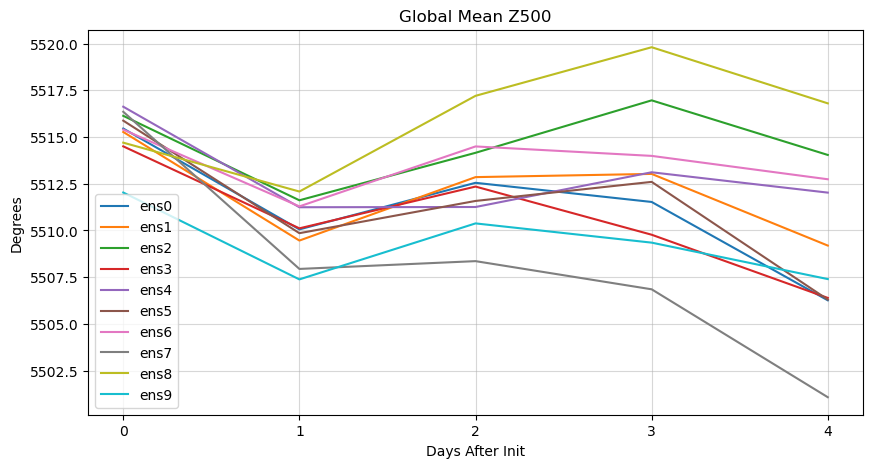

In [37]:
for ie in ds2.ens:
    plt.plot(ds2.time.dt.day[0:5],z500_mean2.isel(ens=ie)[0:5],label="ens"+str(ds2.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds2.time.dt.day[0:5],np.arange(5))
#plt.ylim(275.5,277.0)
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('Global Mean Z500')

Text(0.5, 1.0, 'Global Mean Z500')

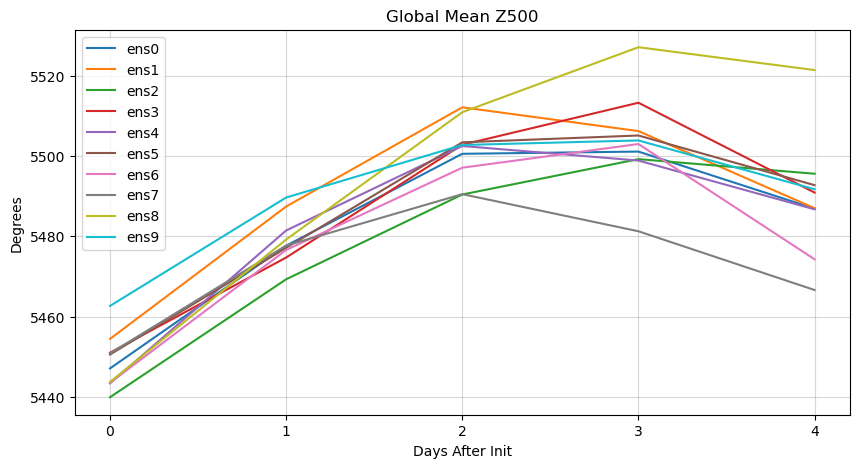

In [39]:
for ie in ds2.ens:
    plt.plot(ds2.time.dt.day[0:5],z500_us2.mean(('lat','lon')).isel(ens=ie)[0:5],label="ens"+str(ds2.ens[ie].data))
plt.rcParams["figure.figsize"] = (10,5)
plt.grid(alpha=0.5)
plt.legend()
plt.xticks(ds2.time.dt.day[0:5],np.arange(5))
#plt.ylim(275.5,277.0)
plt.xlabel('Days After Init')
plt.ylabel('Degrees')
plt.title('Global Mean Z500')

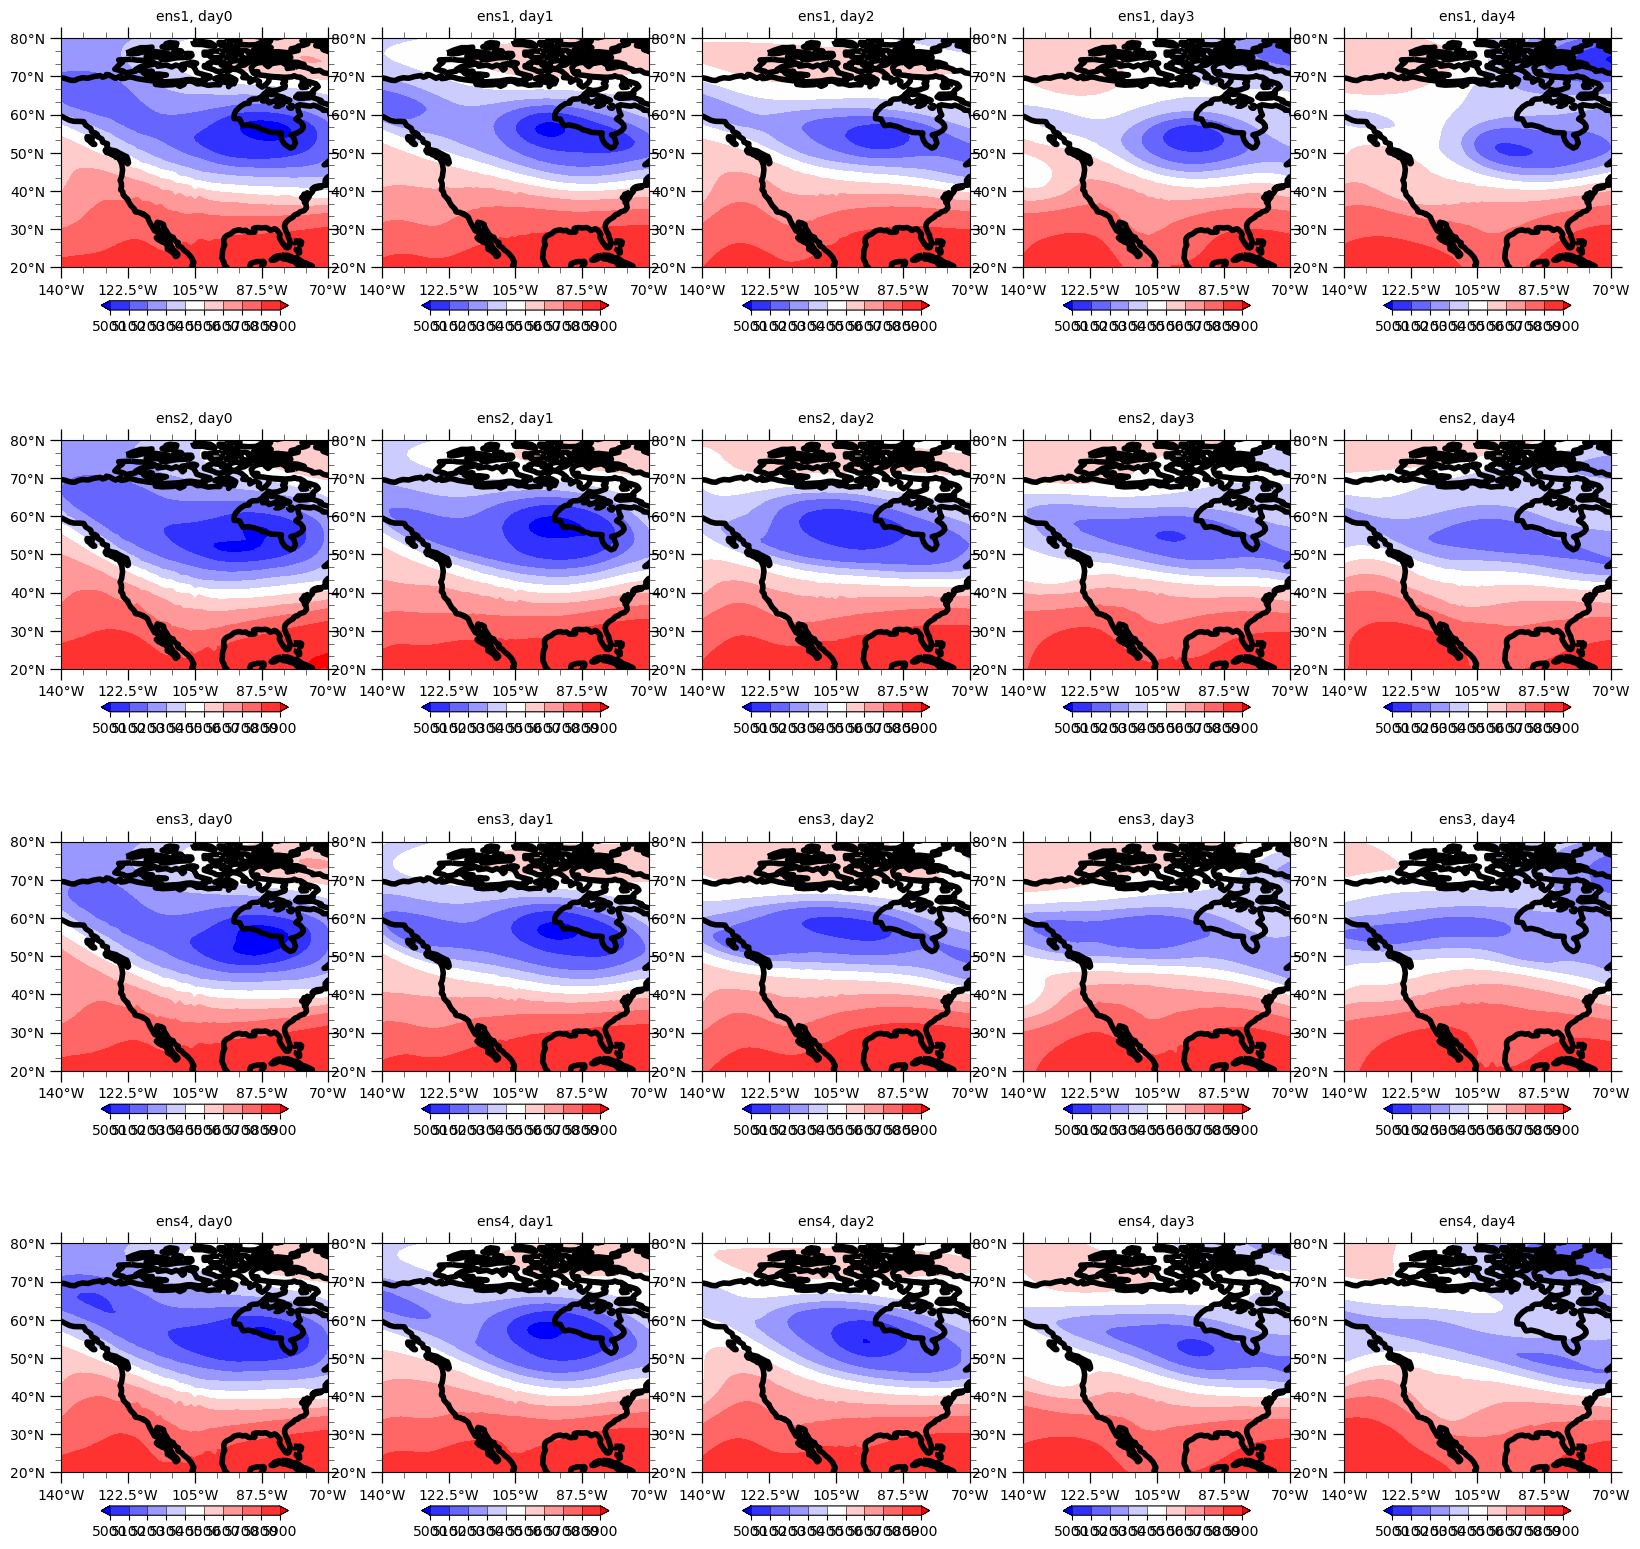

In [41]:
fig=plt.figure(figsize=(20,20))
levels=np.arange(5000,6000,100)
var_plot_panels(ds2.zg_500[1,0],4,5,1, levels,'ens1, day0','bwr')
var_plot_panels(ds2.zg_500[1,1],4,5,2, levels,'ens1, day1','bwr')
var_plot_panels(ds2.zg_500[1,2],4,5,3, levels,'ens1, day2','bwr')
var_plot_panels(ds2.zg_500[1,3],4,5,4, levels,'ens1, day3','bwr')
var_plot_panels(ds2.zg_500[1,4],4,5,5, levels,'ens1, day4','bwr')
var_plot_panels(ds2.zg_500[2,0],4,5,6, levels,'ens2, day0','bwr')
var_plot_panels(ds2.zg_500[2,1],4,5,7, levels,'ens2, day1','bwr')
var_plot_panels(ds2.zg_500[2,2],4,5,8, levels,'ens2, day2','bwr')
var_plot_panels(ds2.zg_500[2,3],4,5,9, levels,'ens2, day3','bwr')
var_plot_panels(ds2.zg_500[2,4],4,5,10, levels,'ens2, day4','bwr')
var_plot_panels(ds2.zg_500[3,0],4,5,11, levels,'ens3, day0','bwr')
var_plot_panels(ds2.zg_500[3,1],4,5,12, levels,'ens3, day1','bwr')
var_plot_panels(ds2.zg_500[3,2],4,5,13, levels,'ens3, day2','bwr')
var_plot_panels(ds2.zg_500[3,3],4,5,14, levels,'ens3, day3','bwr')
var_plot_panels(ds2.zg_500[3,4],4,5,15, levels,'ens3, day4','bwr')
var_plot_panels(ds2.zg_500[4,0],4,5,16, levels,'ens4, day0','bwr')
var_plot_panels(ds2.zg_500[4,1],4,5,17, levels,'ens4, day1','bwr')
var_plot_panels(ds2.zg_500[4,2],4,5,18, levels,'ens4, day2','bwr')
var_plot_panels(ds2.zg_500[4,3],4,5,19, levels,'ens4, day3','bwr')
var_plot_panels(ds2.zg_500[4,4],4,5,20, levels,'ens4, day4','bwr')

## 3. check reanalysis

In [42]:
obs_dir = "/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/"

In [44]:
filenames_obs = f"{obs_dir}e5.oper.an.pl.128_129_z.ll025sc.202102*.nc"
glob.glob(filenames_obs)

['/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021600_2021021623.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021200_2021021223.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021300_2021021323.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021800_2021021823.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021100_2021021123.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021020700_2021020723.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021022700_2021022723.nc',
 '/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021000_

In [ ]:
def pre_process(ds):
    

In [ ]:
pre_process = 
ds_obs = xr.open_mfdataset()